In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
defaults.device=torch.device('cpu')

In [ ]:
from fastai.text import *

## Preparing the data

In [ ]:
from pathlib import PurePosixPath
path = PurePosixPath(base_dir)
path.dir()

AttributeError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Test3/'

MessageError: ignored

It only contains one csv file, let's have a look at it.

In [ ]:
df = pd.read_csv(path/'Test.csv')
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
df['class'][0]

2

In [ ]:
data_lm = TextDataBunch.from_csv(path, 'Test.csv')

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:498: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
13019, 5176, 9659, 23112, 24046...
  if getattr(ds, 'warn', False): warn(ds.warn)


In [ ]:
data_lm.save()

Next time we launch this notebook, we can skip the cell above that took a bit of time (and that will take a lot more when you get to the full dataset) and load those results like this:

In [ ]:
data = load_data(path)

In [ ]:
data = TextClasDataBunch.from_csv(path, 'Test.csv')
data.show_batch()

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:498: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
13019, 18238, 1783, 19343, 18018...
  if getattr(ds, 'warn', False): warn(ds.warn)


text,target
xxbos 3,12436
xxbos 4,14816
xxbos 3,24635
xxbos 3,7183
xxbos 3,11320


### With the data block API

In [ ]:
data = (TextList.from_csv(path, 'Test.csv', cols='tweet')
                .random_split_by_pct()
                .label_from_df(cols='class')
                .databunch())

## Language model

In [ ]:
data.show_batch()

text,target
xxbos xxmaj was finna slit my eyebrows up in the shop but na xxrep 6 h . \r \n . \r \n . \r \n . \r \n . \r \n . \r \n . \r \n . \r \n . \r \n . \r \n . \r \n . \r \n . \r \n . \r,2
"xxbos xxup rt xxunk _ : a couple 👫 is "" a couple "" 👌 xxmaj not "" a couple & & one "" 👫 🚶 xxmaj not "" a couple & & some "" 👫 🙆 🙅 💁 xxmaj not "" a couple & & plenty "" 👫 xxrep 5 💃 xxmaj no hoes xxmaj no …",1
xxbos xxup rt xxunk : xxmaj charlie xxmaj sheen xxunk to porn star http : / / t.co / xxunk \r \n xxmaj xxunk # xxmaj health xxmaj tips xxmaj sex xxmaj toy http : / / t.co / xxmaj xxunk m xxmaj the xxmaj adult xxmaj toys # xxup kiss …,2
"xxbos xxup rt xxunk : "" i let ma chain hang low ... "" \r \n "" xxmaj two xxunk ... "" \r \n "" xxmaj gold all in ma chain ... "" \r \n "" i keep a chain xxunk hoe ... "" \r \n "" xxmaj niggas staring at ma xxunk …",1
"xxbos xxup rt xxunk _ : xxup lma xxrep 4 o xxup rt xxup xxunk : xxmaj white people lmaoo xxup rt xxunk : xxmaj filth . xxup rt xxunk : xxmaj when she says "" xxmaj come get this pussy "" https : / / t …",1


Note that language models can use a lot of GPU, so you may need to decrease batchsize here.

In [ ]:
bs=48

Now let's grab the full dataset for what follows.

In [ ]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/home/ubuntu/.fastai/data/imdb/test'),
 PosixPath('/home/ubuntu/.fastai/data/imdb/tmp_clas'),
 PosixPath('/home/ubuntu/.fastai/data/imdb/README'),
 PosixPath('/home/ubuntu/.fastai/data/imdb/unsup'),
 PosixPath('/home/ubuntu/.fastai/data/imdb/train'),
 PosixPath('/home/ubuntu/.fastai/data/imdb/tmp_lm'),
 PosixPath('/home/ubuntu/.fastai/data/imdb/models'),
 PosixPath('/home/ubuntu/.fastai/data/imdb/imdb.vocab')]

In [ ]:
(path/'train').ls()

[PosixPath('/home/ubuntu/.fastai/data/imdb/train/neg'),
 PosixPath('/home/ubuntu/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/home/ubuntu/.fastai/data/imdb/train/pos'),
 PosixPath('/home/ubuntu/.fastai/data/imdb/train/labeledBow.feat')]

The reviews are in a training and test set following an imagenet structure. The only difference is that there is an `unsup` folder on top of `train` and `test` that contains the unlabelled data.

We're not going to train a model that classifies the reviews from scratch. Like in computer vision, we'll use a model pretrained on a bigger dataset (a cleaned subset of wikipedia called [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset)). That model has been trained to guess what the next word, its input being all the previous words. It has a recurrent structure and a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.

We are going to use that 'knowledge' of the English language to build our classifier, but first, like for computer vision, we need to fine-tune the pretrained model to our particular dataset. Because the English of the reviews left by people on IMDB isn't the same as the English of wikipedia, we'll need to adjust the parameters of our model by a little bit. Plus there might be some words that would be extremely common in the reviews dataset but would be barely present in wikipedia, and therefore might not be part of the vocabulary the model was trained on.

This is where the unlabelled data is going to be useful to us, as we can use it to fine-tune our model. Let's create our data object with the data block API (next line takes a few minutes).

In [ ]:
data_lm = (TextList.from_csv(path,'Test.csv',cols='tweet')
           #Inputs: all the text files in path
       
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .random_split_by_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('data_lm48W.pkl')

We have to use a special kind of `TextDataBunch` for the language model, that ignores the labels (that's why we put 0 everywhere), will shuffle the texts at each epoch before concatenating them all together (only for training, we don't shuffle for the validation set) and will send batches that read that text in order with targets that are the next word in the sentence.

The line before being a bit long, we want to load quickly the final ids by using the following cell.

In [ ]:
data_lm = load_data(path, 'data_lm48W.pkl', bs=bs)

In [ ]:
data_lm.show_batch()

idx,text
0,4 ! xxup rt @80sbaby4life : xxmaj you ever fuck a bitch and she start to cry ? xxmaj you be confused as shit xxbos xxrep 9 ! xxup rt xxunk : @viva_based she look like a tranny xxbos xxrep 13 ! xxup rt xxunk : xxmaj the shit you hear about me might be true or it might be faker than the bitch who told it to ya xxunk
1,"working cuz i wanna see my team rich . "" http : / / t.co / xxunk xxbos "" xxmaj fuck 5 / 0 i make my own rules . xxmaj suck my dragon balls bitch call me goku "" xxbos "" xxmaj xxunk xxup xxunk boxes with xxunk "" all i see is the ability to bring flappy - bird in xxunk via xxup xxunk xxunk and bird xxunk"
2,"http : / / t.co / xxunk xxbos # porn , # android , # iphone , # ipad , # sex , # xxx , | # xxmaj hairy | xxmaj hairy pussy http : / / t.co / xxunk xxbos # porn , # android , # iphone , # ipad , # sex , # xxx , | # xxmaj hairy | hairy pussy http : /"
3,“ @highclasscapri : @what_evaittakes lmao i minds well be a hoe for all that 😐 ” 😳 😳 i ai n't mean like that girl lol xxbos “ @highclasscapri : @what_evaittakes no bitch hurry up xxunk so hungry i ca n't focus 😩 xxbos “ @highclasscapri : @what_evaittakes o xxrep 5 h yes bitch xxunk ready t ? 😏 😈 xxbos “ @highclasscapri : @what_evaittakes woke up and bitches was
4,"you ugly ass big bird looking bitch , shut the fuck up . ” < < xxmaj that 's pretty much xxup in xxup your xxup face ! \r \n xxmaj xxunk ! xxbos “ xxunk _ : xxmaj why u ca n't just love ? ” xxmaj because we do n't love these hoes xxbos “ xxunk : xxunk "" they played a great job "" who 's"


We can then put this in a learner object very easily with a model loaded with the pretrained weights. They'll be downloaded the first time you'll execute the following line and stored in `~/.fastai/models/` (or elsewhere if you specified different paths in your config file).

In [ ]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


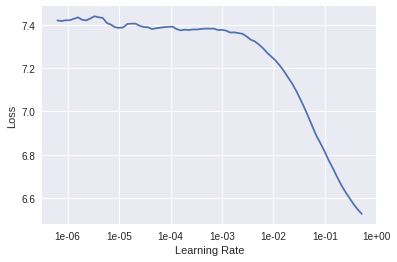

In [ ]:
learn.recorder.plot(skip_end=15)

In [ ]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: ignored

In [ ]:
learn.save('fit_head48')

In [ ]:
learn.load('fit_head');

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(1, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.932184,3.935689,0.305580,30:27


In [ ]:
learn.save('fine_tuned48w2')

How good is our model? Well let's try to see what it predicts after a few given words.

In [ ]:
learn.load('fine_tuned48w2');

In [ ]:
TEXT = "Hello"
N_WORDS = 40
N_SENTENCES = 2

In [ ]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

Hello Hazel colored record , a b - Green , BLUE , NOW MORNING GREEN , SHADES MONEY AND HIS FRIENDS BITCH IS THE ASIAN
Hello Mary ca n't be a bitch for a date xxbos This bitch is a big bitch xxbos RT _ _ : i had a bitch with a bad bitch . # Http : / / t.co


We not only have to save the model, but also it's encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [ ]:
learn.save_encoder('fine_tuned_enc 48w12')

Now, we'll create a new data object that only grabs the labelled data and keeps those labels. Again, this line takes a bit of time.

In [ ]:
path = untar_data(URLs.IMDB)

In [ ]:
classes=[0,1,2]

In [ ]:
data_clas = (TextList.from_csv(path,'Test.csv', vocab=data_lm.vocab,cols='tweet')
             #grab all the text files in path
             .random_split_by_pct()
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_df(cols='class')
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('data_clas48w32.pkl')

In [ ]:
data_clas = load_data(path, 'data_clas48w.pkl', bs=48)

In [ ]:
data_clas.show_batch()

text,target
xxbos xxmaj was finna slit my eyebrows up in the shop but na xxrep 6 h . \r \n . \r \n . \r \n . \r \n . \r \n . \r \n . \r \n . \r \n . \r \n . \r \n . \r \n . \r \n . \r \n . \r,2
"xxbos xxup rt @huhwhatsacondom : xxup xxunk xxrep 6 u h xxrep 4 😭 xxrep 4 😂 “ xxunk : xxmaj kobe , last night yelling at xxmaj dwight xxmaj howard : "" xxmaj you a bitch ass n xxrep 5 * "" ? https : / / t.co …",1
"xxbos xxup xxunk plays next xxmaj fri ( 5 - 16 - xxunk the xxmaj xxunk xxmaj xxunk + ) in xxmaj xxunk , xxup wi with xxmaj charlie xxmaj parr & & xxmaj xxunk xxmaj xxunk of xxmaj uncle xxmaj frank ! xxmaj tickets 15 $",2
xxbos ★ @ ★ @ ★ @ ★ @ ★ xxup grand xxup opening ! ★ @ ★ @ ★ @ ★ @ ★ xxup top xxup class ★ xxmaj oriental xxmaj massage ★ xxup perfect ! ★ http : / / t.co / xxunk,2
"xxbos xxup rt xxunk _ : "" @vintage_monroe _ : “ @vineforthebyrd : xxmaj girlfriends xxmaj be xxmaj like xxrep 4 . 😂 😭 🙌 💯 https : / / t.co / xxunk we do n't want him "" 😂 😂 😭 😭 💀 💀",1


We can then create a model to classify those reviews and load the encoder we saved before.

In [ ]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.4)
learn.load_encoder('fine_tuned_enc 48w')

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


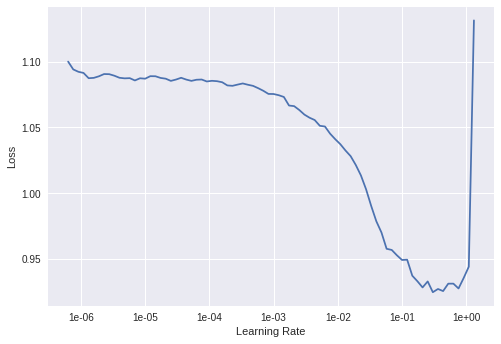

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.476561,0.421985,0.843624,11:16


In [ ]:
learn.save('first48')

In [ ]:
learn.load('first');

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.301367,0.280414,0.895682,14:00


In [ ]:
learn.save('h48w')

In [ ]:
learn.load('h48w');

In [ ]:
learn.freeze_to(-4)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.276980,0.268199,0.903551,34:42


In [ ]:
learn.load('fourth48')

FileNotFoundError: ignored

In [ ]:
learn.load('third');

In [ ]:
learn=load_learner(path)

AttributeError: ignored

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.317453,0.282666,0.896691,01:12
2,0.293209,0.278877,0.895278,01:11


In [ ]:
print(learn.predict(' people shit on street'))

AttributeError: ignored